In [1]:
import pandas as pd 

In [5]:
train_MELD_df = pd.read_csv('../MELD_DATA/train_sent_emo.csv')
test_MELD_df = pd.read_csv('../MELD_DATA/test_sent_emo.csv')
val_MELD_df = pd.read_csv('../MELD_DATA/dev_sent_emo.csv')

In [3]:
train_MELD_df.head(20)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
5,6,"Now youll be heading a whole division, so you...",The Interviewer,neutral,neutral,0,5,8,21,"00:16:41,126","00:16:44,337"
6,7,I see.,Chandler,neutral,neutral,0,6,8,21,"00:16:48,800","00:16:51,886"
7,8,But therell be perhaps 30 people under you so...,The Interviewer,neutral,neutral,0,7,8,21,"00:16:48,800","00:16:54,514"
8,9,Good to know.,Chandler,neutral,neutral,0,8,8,21,"00:16:59,477","00:17:00,478"
9,10,We can go into detail,The Interviewer,neutral,neutral,0,9,8,21,"00:17:00,478","00:17:02,719"


In [6]:
print(f'Number of Utterances in the Training Set: ', len(train_MELD_df))
print(f'Number of Utterances in the Testing Set: ', len(test_MELD_df))
print(f'Number of Utterances in the Validation Set: ', len(val_MELD_df))

Number of Utterances in the Training Set:  9989
Number of Utterances in the Testing Set:  2610
Number of Utterances in the Validation Set:  1109


In [7]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model to evaluation mode to prevent updates to weights
model.eval()

def embedding_func(speech_line):
    """
    Generate BERT embedding for a given speech line.

    Parameters:
    - speech_line: A string representing a single line of speech.

    Returns:
    - A 768-dimensional BERT embedding as a list of floats.
    """
    # Tokenize the input text and convert to PyTorch tensors
    inputs = tokenizer(speech_line, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Get the model outputs (embedding) from the last hidden layer
    with torch.no_grad():
        outputs = model(**inputs)
    
    # The embeddings are in 'last_hidden_state', take the [CLS] token as the sentence-level embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    
    # Convert to a Python list (detaching from the computation graph)
    embedding = cls_embedding.squeeze().tolist()

    return embedding

In [12]:
def create_dialogue_graphs(df):

    dialogues = df.groupby('Dialogue_ID')
    dialogue_graphs = []

    # Create a placeholder for null embeddings (assuming embeddings are vectors)
    null_embedding = [0] * 768  

    # To iterate over each group
    for _, dialogue in dialogues:

        participants = dialogue['Speaker'].unique()
        G = []

        for index, row in dialogue.iterrows():
        
            G_i = {'X': {}, 'Y': 'Uninitialized'}
            G_i['Y'] = row['Emotion']
            speaker = row['Speaker']

            # Initialize speaker nodes for each timestamp
            for p in participants:
                if p == speaker:
                    speaker_embedding = embedding_func(row['Utterance'])
                    speaker_edges = [f'{node}_{index}' for node in participants if node != speaker]
                    G_i['X'][f'{p}_{index}'] = {'embedding': speaker_embedding, 'edges': speaker_edges}
                else:    
                    G_i['X'][f'{p}_{index}'] = {'embedding': null_embedding, 'edges': []}

            G.append(G_i)

        dialogue_graphs.append(G)


    return dialogue_graphs

In [18]:
val_dialogue_graphs = create_dialogue_graphs(val_MELD_df)
train_dialogue_graphs = create_dialogue_graphs(train_MELD_df)
test_dialogue_graphs = create_dialogue_graphs(test_MELD_df)

In [20]:
import matplotlib.pyplot as plt


def plot_speakers_vs_utterances(df, title):
    dialogues = df.groupby('Dialogue_ID')

    num_speakers = []
    num_utterances = []

    # To iterate over each group
    for _, dialogue in dialogues:
        num_speakers.append(len(dialogue['Speaker'].unique()))
        num_utterances.append(len(dialogue))

    
    plt.figure(figsize=(8, 6))
    plt.scatter(num_utterances, num_speakers, color='blue')
    plt.title(f'Number of Speakers vs Number of Utterances ({title})')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(True)
    plt.show()


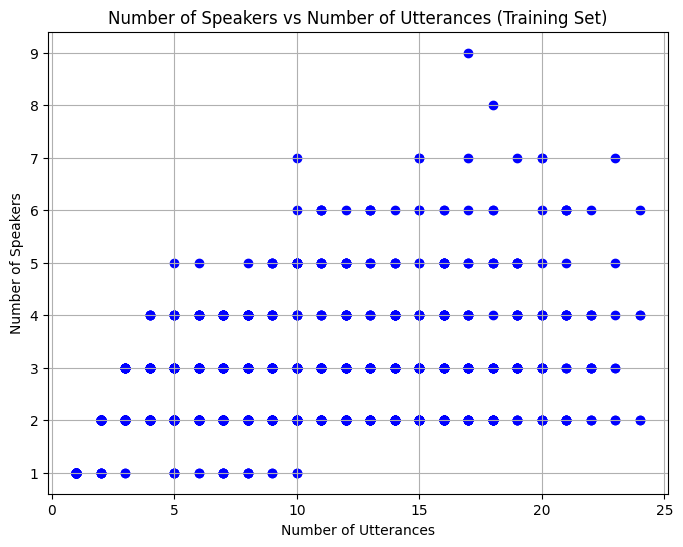

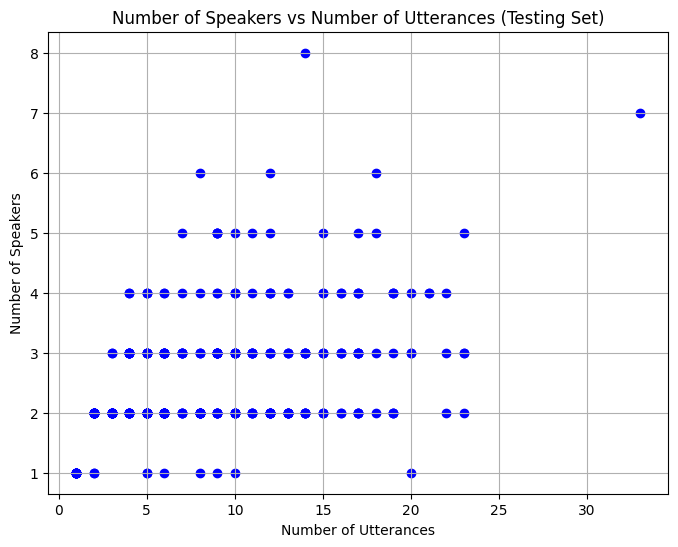

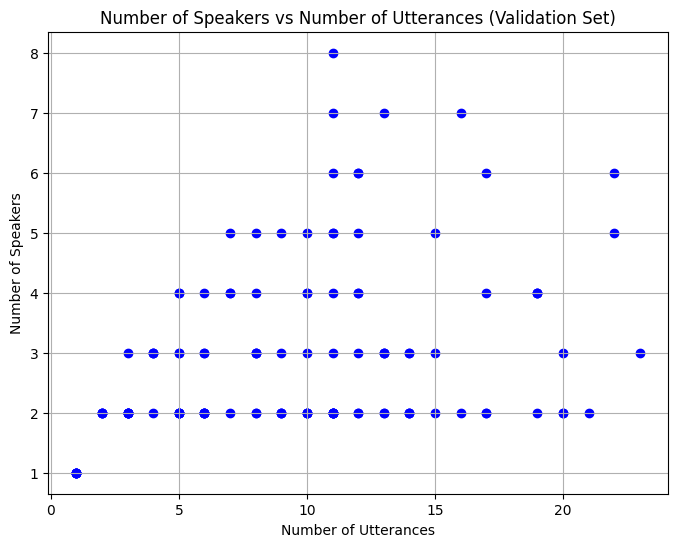

In [21]:
plot_speakers_vs_utterances(train_MELD_df, 'Training Set')
plot_speakers_vs_utterances(test_MELD_df, 'Testing Set')
plot_speakers_vs_utterances(val_MELD_df, 'Validation Set')

In [22]:
import pickle

with open('data/ERC/val_dialogue_graphs.pkl', 'wb') as f:
    pickle.dump(val_dialogue_graphs, f)

with open('data/ERC/train_dialogue_graphs.pkl', 'wb') as f:
    pickle.dump(train_dialogue_graphs, f)

with open('data/ERC/test_dialogue_graphs.pkl', 'wb') as f:
    pickle.dump(test_dialogue_graphs, f)